# A Data‑Driven Study of the Alone TV Series: Survival, Strategy, and Screens



## Why we chose this project?
Alone is s survival TV series where 10 survivalists are dropped in an extremely remote area (Arctic winter) and must fend for themselves. Its impressive to see how the winning contestants use their skills, endurance, and mental fortitude to last 100 days in such a harsh living condition.

## Data Description
It uses a collection of datasets about the TV series:

1. `survivalists.csv`
A data frame of survivalists across all 9 seasons detailing name and demographics, location and profession, result, days lasted, reasons for tapping out (detailed and categorised), page URL.

| Feature Name   | Description |
| -------- | ------- |
| `season`  | The season number   |
| `name` | Name of the survivalist     |
| `version` | The version country code (currently only US but being preppred or other versions)|
| `id` | Survivalist unique ID |
| `age` | Age of survivalist |
| `gender` | Gender |
| `city` |  City |
| `state` | State |
| `country` | Country |
|`result`| Place the survivalist finished in the season|
| `days_lasted` | The number of days lasted in the game before tapping out or winning|
| `medically_evacuated` | Logical. If the survivalist was medically evacuated from the game |
| `reason_tapped_out` | The reason the survivalist tapped out of the game. NA means they were the winner |
| `reason_category` | A simplified category of the reason for tapping out |
| `team` | The team they were associated with (only for season 4)|
| `day_linked_up` | Day the team members linked up |
| `profession` | Profession of the survivalist |
---

2. `episodes.csv`
This dataset contains details of each episode including the title, number of viewers, beginning quote and IMDb rating.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `episode_number_overall` | Episode number across seasons |
| `episode` | Episode number |
| `title` | Episode title |
| `air_date` | Date the episode originally aired |
| `viewers` | Number of viewers in the US (millions) |
| `quote` | The beginning quote |
| `author` | Author of the beginning quote |
|`imdb_rating` | IMDb rating of the episode |
| `n_ratings` | Number of ratings given for the episode |
----

3. `seasons.csv`
The season summary dataset includes location, latitude and longitude, and other season level information. It includes the date of drop off where the information exists.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `location` | Location |
| `country` | Country |
| `n_survivors` | Number of survivalists in the season. In season 4 there were 7 teams of 2 |
| `lat` | Latitude |
| `lon` | Longitude |
| `date_drop_off` | The date the survivalists were dropped off |
---

4. `loadouts.csv`
Each survivalist is allowed to take with them 10 items. This dataset includes information on each survivalist’s loadout.

| Feature Name   | Description |
| -------- | ------- |
| `version` | Country code for the version of the show |
| `season` | The season number |
| `id` | Survivalist unique ID |
| `name` | Name of the survivalist |
| `item_number` | Item number |
| `item_detailed` | Detailed loadout item description |
| `item` | Loadout item. Simplified for aggregation |

#### Mounting from drive for csv files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing necessary libraries

In [ ]:
! pip install squarify

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np
import squarify

Reading and Merging csv files into one dataframe

In [ ]:
epi = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/Assignment/episodes.csv')
ses = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/Assignment/seasons.csv')
sur = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/Assignment/survivalists.csv')
load = pd.read_csv('/content/drive/MyDrive/Spring2026/UnsupervisedML/Assignment/loadouts.csv')


Merging episode level and contestant level data duplicates the rows

In [ ]:
import pandas as pd

# -----------------------------
# 1. Normalize version column
# -----------------------------
for _df in [epi, ses, sur, load]:
    if 'version' not in _df.columns:
        _df['version'] = 'US'


if 'id' not in sur.columns:
    sur = sur.copy()
    sur['id'] = sur['name']  # fallback to name as unique identifier

if 'id' not in load.columns:
    load = load.copy()
    load['id'] = load['name']  # fallback for loadouts
# -------------------------------------------------
# 2. PERSON–SEASON dataframe (canonical df)
# -------------------------------------------------
df = (
    sur.merge(
        ses[['version','season','location','lat','lon','date_drop_off']],
        on=['version','season'],
        how='left'
    )
    .groupby(['version','season','id','name'], as_index=False)
    .agg({
        'age': 'first',
        'gender': 'first',
        'profession': 'first',
        'city': 'first',
        'state': 'first',
        'country': 'first',
        'days_lasted': 'max',
        'result': 'first',
        'medically_evacuated': 'first',
        'reason_category': 'first',
        'location': 'first',
        'lat': 'first',
        'lon': 'first',
        'date_drop_off': 'first',
        'team':'first'
    })
)

# Hard guarantee: no duplicate people
assert df[['version','season','id']].duplicated().sum() == 0


# -------------------------------------------------
# 3. EPISODE DATA → season-level aggregation
# -------------------------------------------------
epi_season = (
    epi.groupby(['version','season'], as_index=False)
       .agg({
           'viewers': 'mean',
           'imdb_rating': 'mean',
           'n_ratings': 'mean'
       })
)

df = df.merge(
    epi_season,
    on=['version','season'],
    how='left'
)


# -------------------------------------------------
# 4. LOADOUT DATA → collapse per person
# -------------------------------------------------
load_person = (
    load[['version','season','id','item','item_detailed']]
    .drop_duplicates()
    .groupby(['version','season','id'], as_index=False)
    .agg({'item': list, 'item_detailed' : list})
)

df = df.merge(
    load_person,
    on=['version','season','id'],
    how='left'
)


In [ ]:
df_person_season = df.groupby(['version','season','name'], as_index=False).agg({
    'days_lasted': 'max',
    'age': 'first',
    'gender': 'first'
    # add more as needed
})
df_person_season.head()


,version,season,name,days_lasted,age,gender
0,US,1,Alan Kay,56,40,Male
1,US,1,Brant McGee,6,44,Male
2,US,1,Chris Weatherman,1,41,Male
3,US,1,Dustin Feher,8,37,Male
4,US,1,Joe Robinet,4,24,Male


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   version              94 non-null     object 
 1   season               94 non-null     int64  
 2   id                   94 non-null     object 
 3   name                 94 non-null     object 
 4   age                  94 non-null     int64  
 5   gender               94 non-null     object 
 6   profession           94 non-null     object 
 7   city                 94 non-null     object 
 8   state                93 non-null     object 
 9   country              94 non-null     object 
 10  days_lasted          94 non-null     int64  
 11  result               94 non-null     int64  
 12  medically_evacuated  94 non-null     bool   
 13  reason_category      84 non-null     object 
 14  location             94 non-null     object 
 15  lat                  94 non-null     float

Most of the missing values are present in `day_linked_up`, `team` as some of seasons required team participation

#### **Inferences from M1 Project Phase**

**Correlation Map:**
This correlation heatmap suggests only a few moderate linear relationships among the numeric variables, most correlations are weak.

* Season seems moderately related to viewership metrics
* Days lasted is strongly related to the result variable
* Medical evacuation, latitude/longitude, and age show only very small correlations with outcome and viewership, suggesting no strong simple linear effect from these factors alone.

**Viewership vs Season**

Viewership clearly peaks in Season 1 and then declines in later seasons, while IMDb ratings gradually improve or stay high across later seasons.
This suggests initial viewership was strongest at launch.

**Location effect on survivals and imdb rating**

Survival durations vary noticeably by location, but higher IMDb ratings tend to align with locations where contestants did not necessarily last the longest.This pattern suggests that tougher locations deliver engaging episodes that viewers rate highly, while easier environments do not get better audience ratings.

**Days Lasted and Age**

The scatter plot shows a very weak trend between age and days lasted, with wide spread around the line.Overall, age does not appear to have a strong impact on how long contestants survive.

**Days lasted by reason_category**

Contestants who tap out for medical or health reasons tend to leave earlier, compared with those who leave for family/personal reasons.
Participants exiting due to loss of inventory generally have the shortest stays. Contestants who are medically evacuated tend to stay slightly fewer days on average than those who are not, indicating health issues cut some runs short.

**Days_lasted is strongly right‑skewed.**

Most contestants last relatively few days, and a small number last very long, which is why the raw histogram piles up on the left and stretches out to the right. After applying log, the histogram looks more symmetric, which is useful for methods that assume roughly normal features (e.g., distance based clustering on numeric variables). hese outliers are the people who lasted dramatically longer than the median, reinforcing that survival time has a long right tail. The extreme cases are exactly the “champions".This justifies treating winners and top finishers as a distinct group when you do clustering or segmentation later.


**Average survival days by age band and tap‑out reason**

Across most age bands, contestants who leave for family or personal reasons tend to have higher mean survival days than those who exit due to medical issues or inventory loss.

The 30–39 group that taps out for loss of inventory stands out with especially long average stays, suggesting that some highly resilient players only leave when gear failure, not physical or emotional limits, forces an exit.

**Episode viewers vs season average**

Each point shows how much an episode’s viewers differ from its own season’s average. This highlights over‑performing and under‑performing episodes within each season, helping you identify which episodes attracted unusually high or low audiences given their season baseline.

**Winner Profile**
 The winner for all 9 seasons of "Alone" were United States males around the range of age from 30 to 40 with a variety of professional background from a writer to a construction worker. Items like bow and arrows, trapping wire, ground sheet, and knives are both frequently chosen by winners and associated with higher average survival days.
This suggests that effective shelter, hunting, and trapping tools are common in successful players and may contribute to longer stays in the competition.

## EDA - Sarah Dsouza

Building up on the winner profile

##  Do winners form a distinct contestant profile - combining nationality, gender, outdoor related profession, and survival outcomes compared with non‑winners, and what would such a “winner profile” imply for future casting and fairness in the show’s design?

### *Let us look at the extreme data points - the winners and loosers of the show*

In [ ]:
dfp = df[df['result'].isin([1,10])][['country','age','gender','profession','medically_evacuated','result','season','location','reason_category','days_lasted','item']]
dfw = df[df['result'] == 1][['name','country','age','gender','profession','medically_evacuated','result','season','location','reason_category','days_lasted','city','state','item']]
dfl = df[df['result'] == 10][['name','country','age','gender','profession','medically_evacuated','result','season','location','reason_category','days_lasted','city','state','item']]
print('population size of winners and loosers',len(dfp),'\n','population size of winners',len(dfw),'\n','population size of loosers',len(dfl))

population size of winners and loosers 18 
 population size of winners 10 
 population size of loosers 8


Size of winner and looser population = 16
Size of the winner population = 9
Size of the looser population =  7

*Lets compare the winners and the losers such that we can ensure there is a distinct profile of winner or is it just by chance or lurking variables*

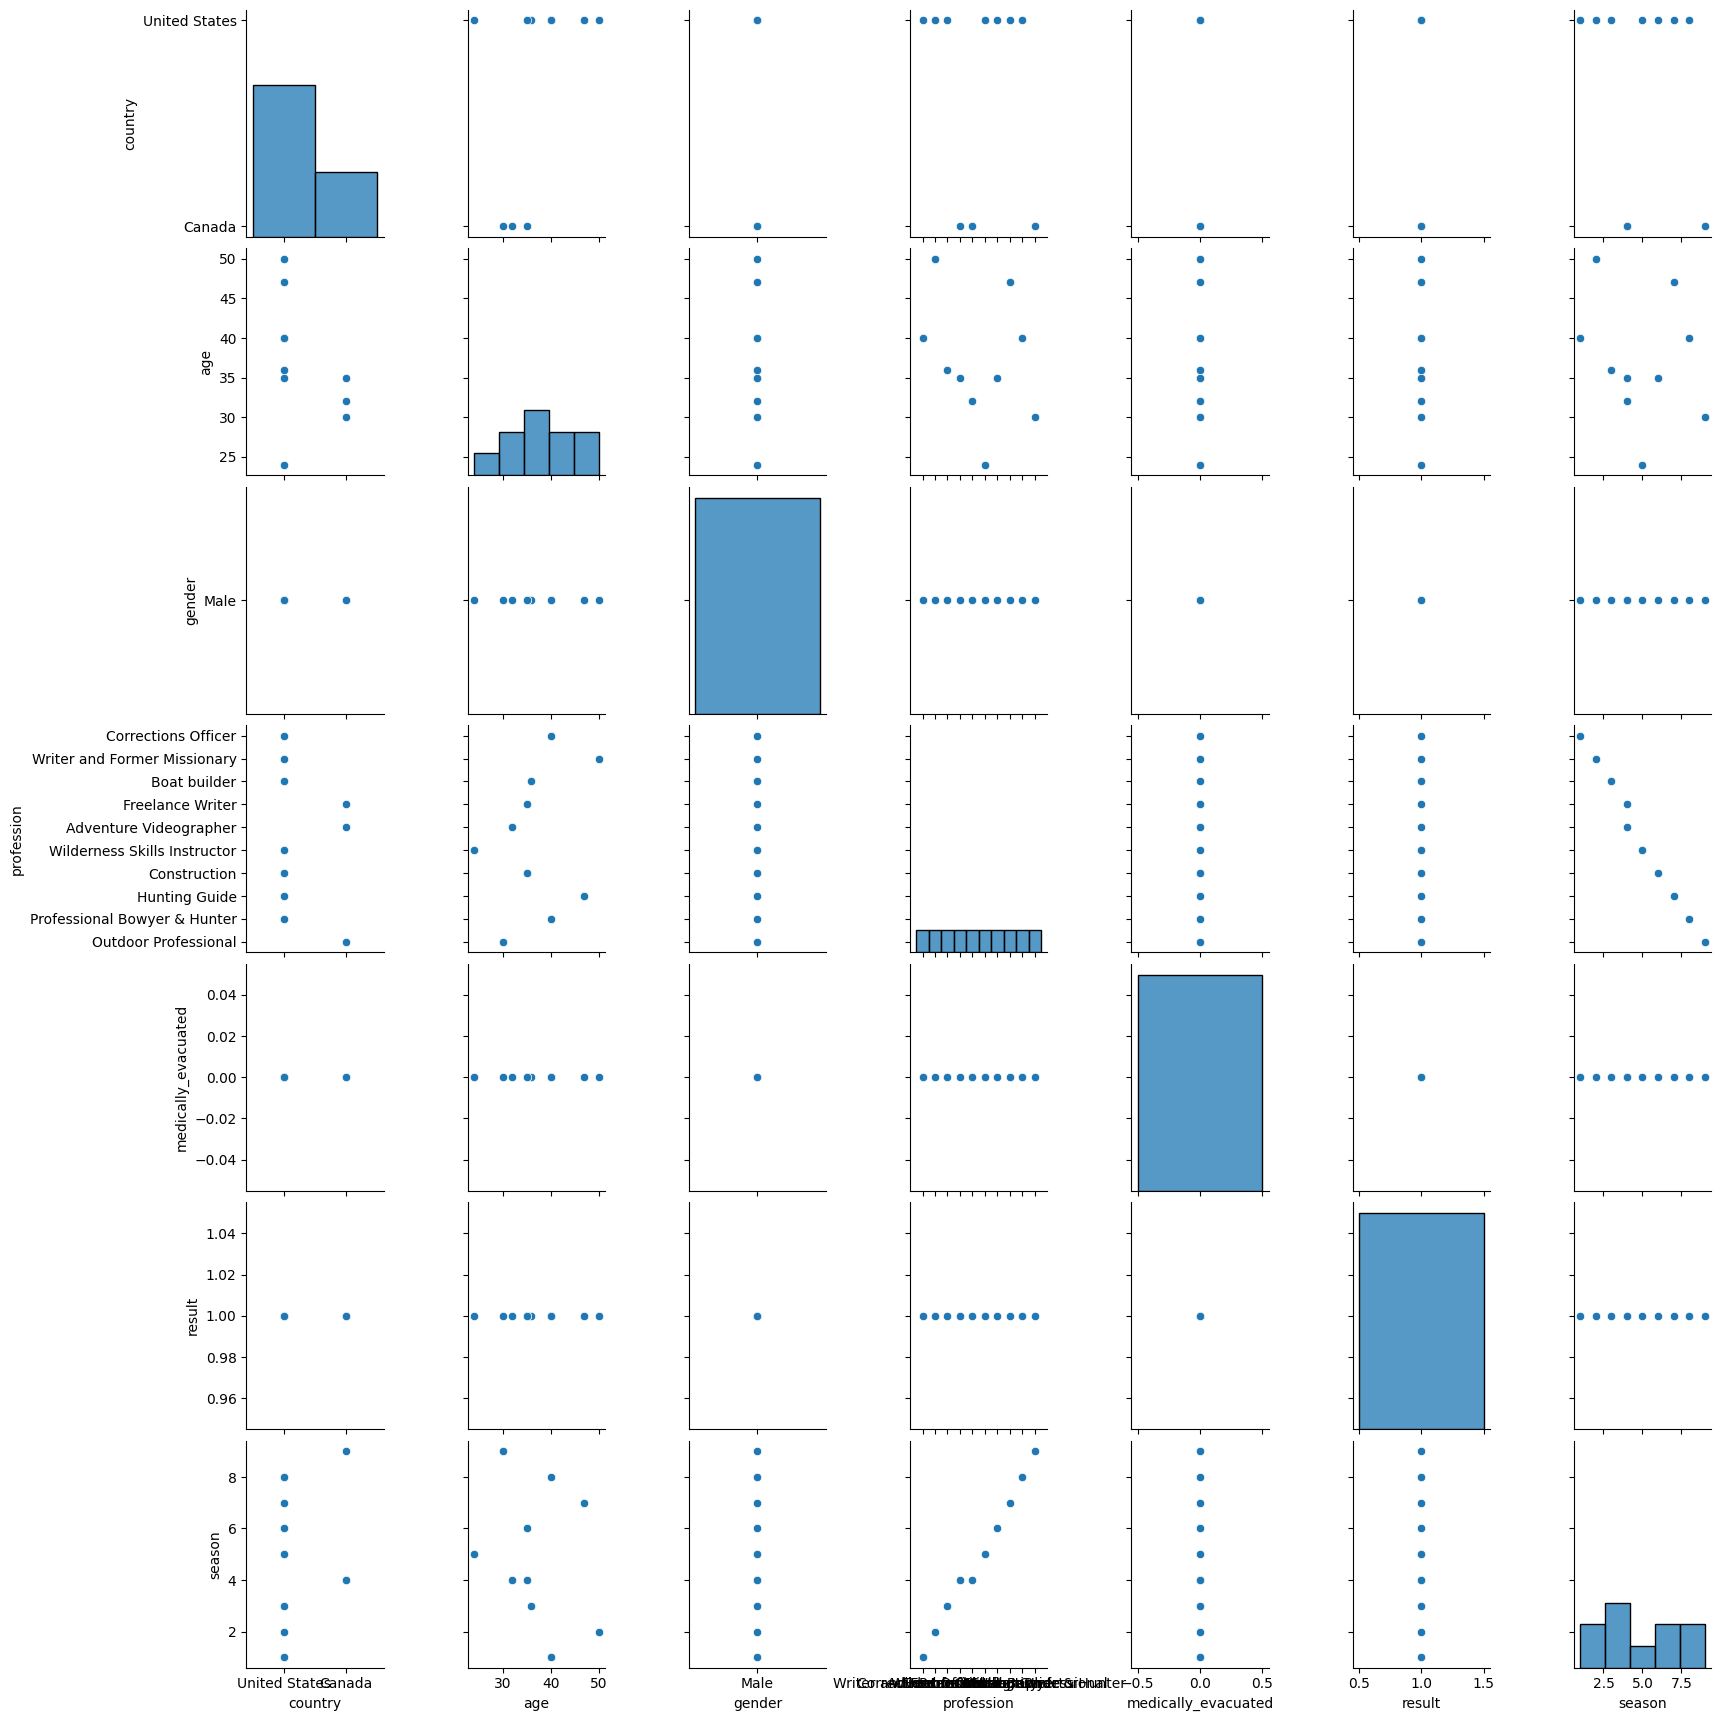

In [ ]:
sns.pairplot(dfw, vars = ['country','age','gender','profession','medically_evacuated','result','season'])

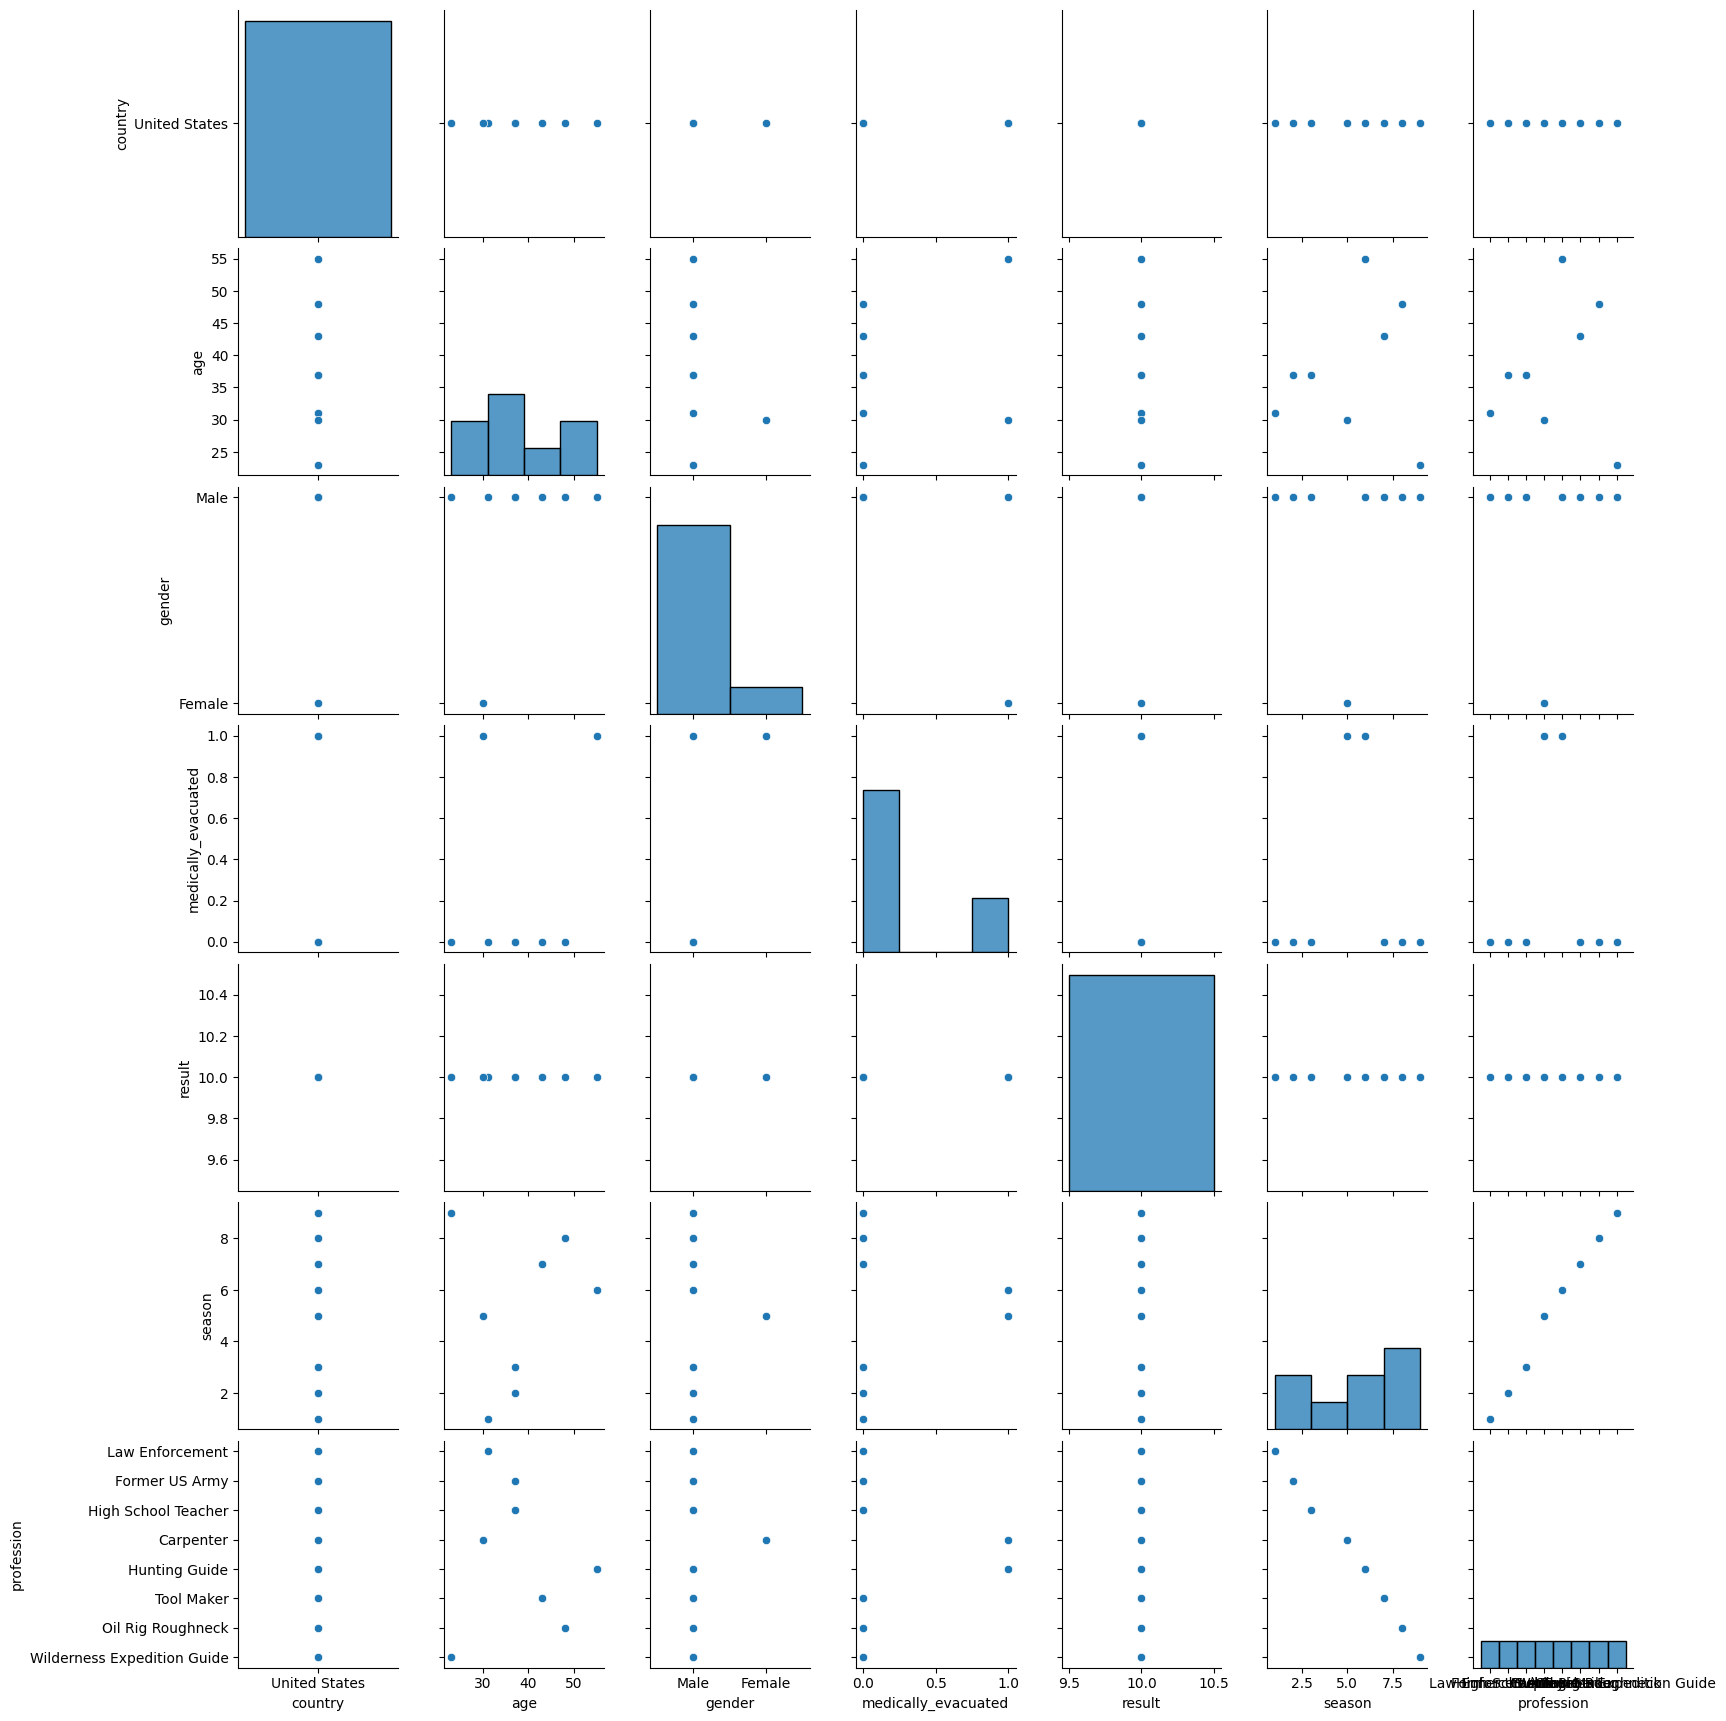

In [ ]:
sns.pairplot(dfl, vars = ['country','age','gender','medically_evacuated','result','season','profession'])

####**Profession vs days lasted effect**

In [ ]:
print('--Loosers Profession--\n',dfl[['profession','days_lasted']].value_counts(),'\n')
print('--Winners Profession--\n',dfw[['profession','days_lasted']].value_counts())

--Loosers Profession--
 profession                   days_lasted
Carpenter                    5              1
Former US Army               6              1
High School Teacher          2              1
Hunting Guide                4              1
Law Enforcement              0              1
Oil Rig Roughneck            6              1
Tool Maker                   10             1
Wilderness Expedition Guide  15             1
Name: count, dtype: int64 

--Winners Profession--
 profession                    days_lasted
Adventure Videographer        75             1
Boat builder                  87             1
Construction                  77             1
Corrections Officer           56             1
Freelance Writer              75             1
Hunting Guide                 100            1
Outdoor Professional          78             1
Professional Bowyer & Hunter  74             1
Wilderness Skills Instructor  60             1
Writer and Former Missionary  66             1
Nam

####**Season wise days lasted between winner and looser**

<Axes: xlabel='season', ylabel='days_lasted'>

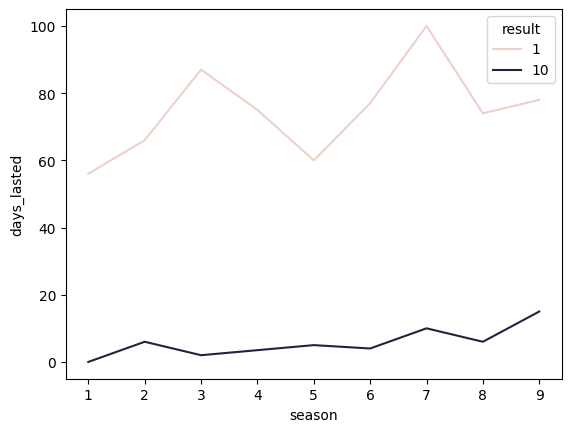

In [ ]:
sns.lineplot(data = dfp, x = 'season', y = 'days_lasted',hue = 'result')

####**We see higher medical evacuation in loosers is that only reason for tapping out?**

<Axes: xlabel='reason_category', ylabel='count'>

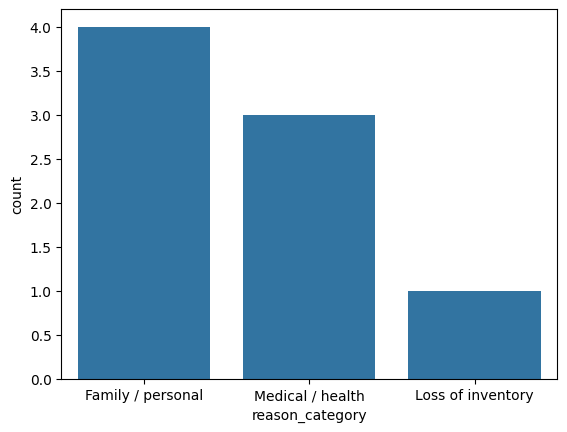

In [ ]:
import seaborn as sns
sns.countplot(x = 'reason_category',data = dfl)

**Observation** Both Family/Personal and Medical/Health category are reasons for tapping out

####**Check out the gear items used for survival for **Loosers****

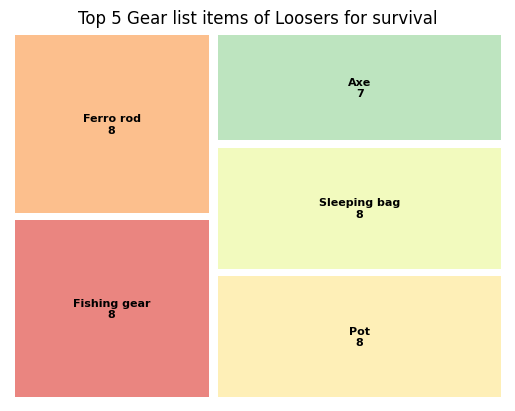

In [ ]:
dfl[['season','gender','age','profession','medically_evacuated','country','reason_category','location','days_lasted','city','state','item']]
all_items = set(cat for sublist in dfl['item'] for cat in sublist)
for item in all_items:
    dfl[item] = dfl['item'].apply(lambda x: 1 if item in x else 0)
dfl = dfl.drop('item', axis=1) #be careful of drop, need to rerun above code
dfl.columns #copy the items manually and paste in i
i = ['Canteen', 'Scotch eyed auger', 'Gillnet', 'Ferro rod',
       'Trapping wire', 'Saw', 'Bow and arrows', 'Multitool', 'Axe',
       'Fishing gear', 'Paracord', 'Bivy bag', 'Rations', 'Knife', 'Shovel',
       'Pot', 'Ground sheet', 'Sleeping bag',]

list1 = []
for x in i:
    list1.append([x,len(dfl[dfl[x] == 1])])
l = pd.DataFrame(list1)
l.columns = ['item','quantity']
l5 = l.sort_values(by = 'quantity', ascending = False).head(5)

#plot the treemap for loosers
labels = [
    f"{item}\n{quantity}"
    for item, quantity in zip(l5["item"], l5["quantity"])
]

import squarify
squarify.plot(sizes=l5['quantity'], label=labels, alpha=.7, color=sns.color_palette("Spectral" ),text_kwargs={"color": "black", "fontsize": 8, "fontweight": "bold"},pad=True)
plt.axis('off')
plt.title('Top 5 Gear list items of Loosers for survival')
plt.show()

####**Check out the gear items used for survival for **Winners****

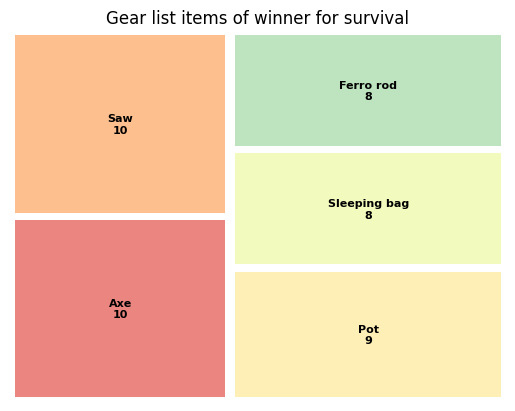

In [ ]:
dfw[['season','gender','age','profession','medically_evacuated','country','reason_category','location','days_lasted','city','state','item']]
all_items_w = set(cat for sublist in dfw['item'] for cat in sublist)
for it in all_items_w:
    dfw[it] = dfw['item'].apply(lambda x: 1 if it in x else 0)
dfw = dfw.drop('item', axis=1)#be careful of drop
dfw.columns
iw = ['Axe', 'Sleeping bag', 'Gillnet', 'Trapping wire',
       'Multitool', 'Saw', 'Wire', 'Bow and arrows', 'Sharpening stone',
       'Fishing gear', 'Bivy bag', 'Slingshot', 'Paracord', 'Frying pan',
       'Canteen', 'Rations', 'Tarp', 'Pot', 'Knife', 'Ferro rod']

listw = []
for x in iw:
    listw.append([x,len(dfw[dfw[x] == 1])])
lw = pd.DataFrame(listw)
lw.columns = ['item','quantity']
lw5 = lw.sort_values(by = 'quantity', ascending = False).head(5)

#plot the treemap for loosers
labels = [
    f"{item}\n{quantity}"
    for item, quantity in zip(lw5["item"], lw5["quantity"])
]

import squarify
squarify.plot(sizes=lw5['quantity'], label=labels, alpha=.7, color=sns.color_palette("Spectral" ),text_kwargs={"color": "black", "fontsize": 8, "fontweight": "bold"},pad=True)
plt.axis('off')
plt.title('Gear list items of winner for survival')
plt.show()

In [ ]:
com = pd.merge(l,lw, on = 'item', suffixes=['_loosers','_winners'])
com

,item,quantity_loosers,quantity_winners
0,Canteen,1,1
1,Gillnet,1,5
2,Ferro rod,8,8
3,Trapping wire,1,7
4,Saw,7,10
5,Bow and arrows,6,6
6,Multitool,3,8
7,Axe,7,10
8,Fishing gear,8,8
9,Paracord,6,5


<Axes: xlabel='gear_used%', ylabel='item'>

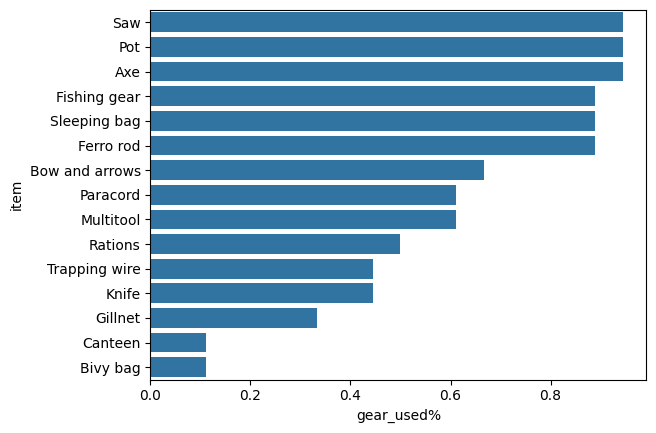

In [ ]:

com['gear_used%'] = (com['quantity_winners'] + com['quantity_loosers'])/len(dfp)
com.sort_values(by = 'gear_used%',ascending = False, inplace = True)
sns.barplot(y = 'item',x = 'gear_used%',data = com)

**Observation and Inferences**

- My assumption that loosers and winners take a unique item that leads them to win or loose is wrong as every item is the gear list is used atleast once by someone
- There are no items that only winners use or only loosers use. Though Saw, Axe which all the winners used are not entirely used by loosers (70%) only. Gear items used cannot be a distinct feature to use.
- No such gear that 80% or more winners took that loosers took less, mostly even loosers took those gears. Gear list is not a discriminative feature for winning and loosing

### A look at  Gender and Location - Is there a bias in casting?
The table showsed that US + Male are mostly the loosers or the winners. Lets look at the population of all 9 seasons


In [ ]:
df['name'].unique().size
unique = df.drop_duplicates(subset='name', keep="first")
print('The percentage of participants who are US and Male',len(unique.loc[(unique['country'] == 'United States') & (unique['gender'] == 'Male')])/len(unique))
print('The percentage of participants who are Feamle',len(unique.loc[(unique['gender'] == 'Female')])/len(unique))
print('The percentage of participants who are Feamle',len(unique.loc[(unique['gender'] == 'Male')])/len(unique))

The percentage of participants who are US and Male 0.6785714285714286
The percentage of participants who are Feamle 0.20238095238095238
The percentage of participants who are Feamle 0.7976190476190477


<Axes: xlabel='count', ylabel='country'>

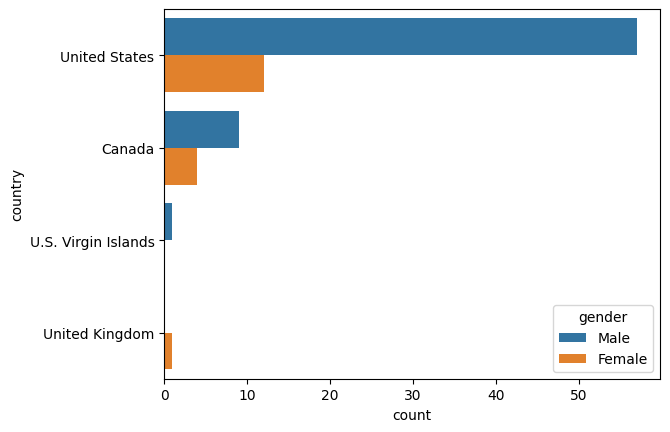

In [ ]:
sns.countplot(y = 'country', hue = 'gender', data = unique)

**Inference**

- The casting director mostly casts for US Male as evident from their population. Out of 94, 84 are unique participants and 10 seem to be repeated.

- 67.8% are US Male. 79.76% are overall males that are casted with only 20.23% Female.

- Thus a clear distinction of winner profile cannot be made as casting director casts more males from the US. Therefore, the data is affected by a certain group. We are cannot be sure of how females would perform if casted more in number.

*Yes it seems to prefer US male particpants*

#### **A look at reasons for tapping out for loosers**
*As we know winners dont tap out, loosers mostly tapped out because of family/personal or medical/health reasons*

In [ ]:
dfl[['season','location','reason_category','gender']].value_counts()

,,,,count
season,location,reason_category,gender,
1,Quatsino,Family / personal,Male,1
2,Quatsino,Family / personal,Male,1
3,Patagonia,Family / personal,Male,1
5,Selenge Province,Medical / health,Female,1
6,Great Slave Lake,Medical / health,Male,1
7,Great Slave Lake,Loss of inventory,Male,1
8,Chilko Lake,Medical / health,Male,1
9,Nunatsiavut,Family / personal,Male,1


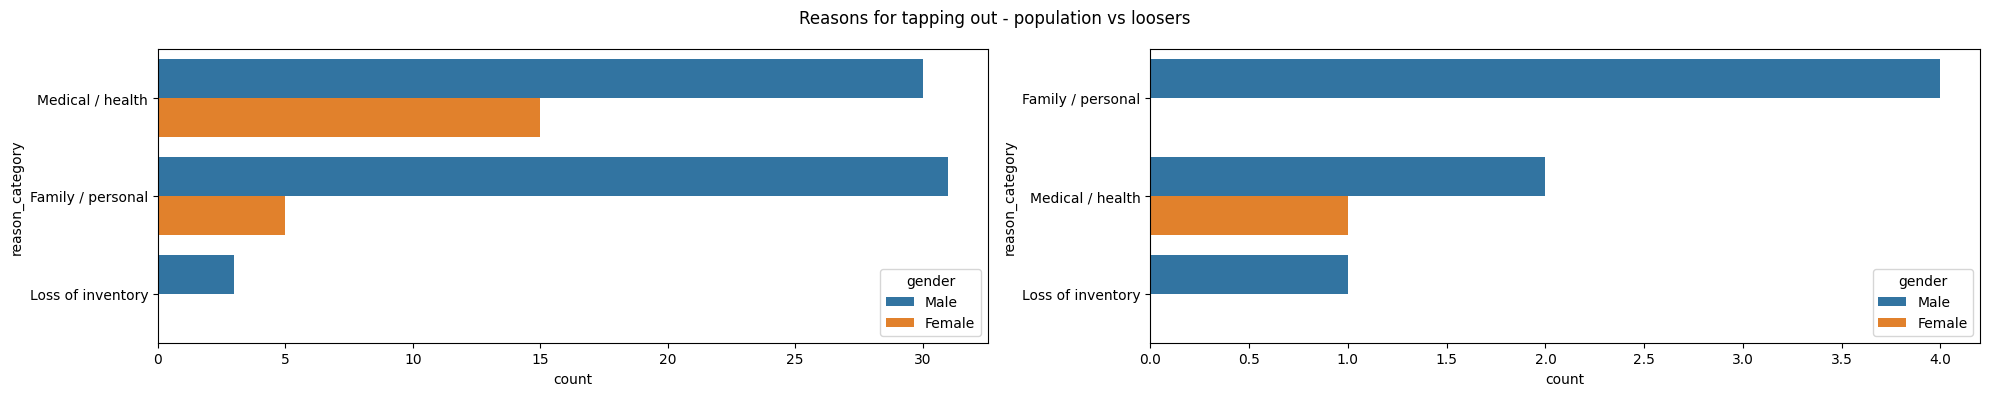

In [ ]:
plt.subplots(1, 2, figsize=(20, 4))
plt.suptitle('Reasons for tapping out - population vs loosers')
plt.subplot(1, 2, 1)
sns.countplot(y = 'reason_category',hue = 'gender', data = df)
plt.subplot(1, 2, 2)
sns.countplot(y = 'reason_category',hue = 'gender', data = dfl)
plt.tight_layout()


**Inferences**
- The overall population taps out mostly due to medical/health followed by family/ personal

- Loosers tap out majorily due to personal or family related issues, which is mostly men.

- Loss of Inventory is not the major reason for tapping out, meaning the survivalist know how to maintain their inventory and use it wisely.

- Women tap out majorily because of medical/ health both in loosers and population as a whole, does this make the casting directors avoid casting women in more number?

- Women dont tap out majorily due to family/personal issues as compared to men.

However, since we saw there is an imbalance of data with men higher in number these assumptions cannot be made entirely as women are not represented more.

#### **Lets dive deeper into why most women are not winning**

In [ ]:
unique[unique['gender'] == 'Female']['reason_category'].value_counts()

,count
reason_category,
Medical / health,13
Family / personal,4


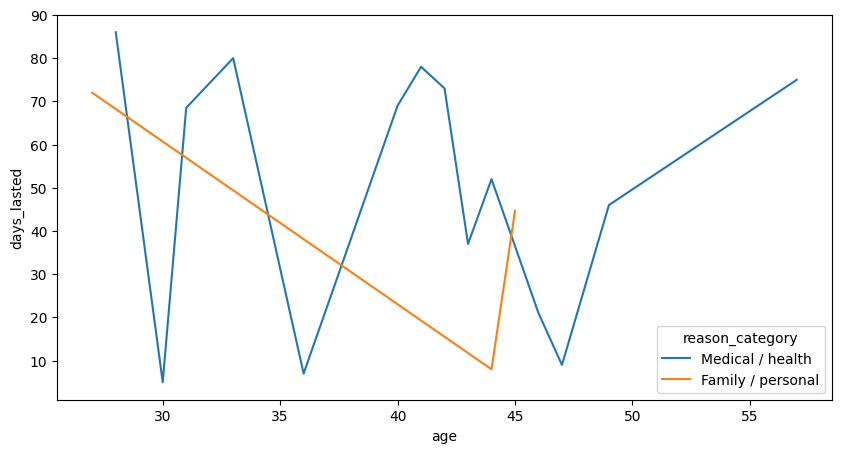

In [ ]:
fem = df[df['gender'] == 'Female'][['reason_category','location','days_lasted','country','state','city','season','age','profession']]
plt.figure(figsize=(10,5))


sns.lineplot(
    data=fem,
    x='age',
    y='days_lasted',
    color = 'blue',
    # legend = True, # Removed as it's not needed with manual patch legend
    hue = 'reason_category',
    errorbar=None
)
plt.show()

**Inference**

- Out 17 women, 13 tap out due to medical and health issues. Medical/Health reasons are major reasons for women to leave the show
- Over the ages, we see that female after 45 years dont tap out due to family/personal reasons but only medical/health reasons.
- Days lasted very a lot for females tapping out due to medical reaons, whereas for family/personal reasons females survival last shorter, with a spike at 45 (can be an outlier)
- Female above 50 are quite stronger and even though they tap out due to medical reasons they last longer in the show

#### **Age analysis - Winner vs Loosers**

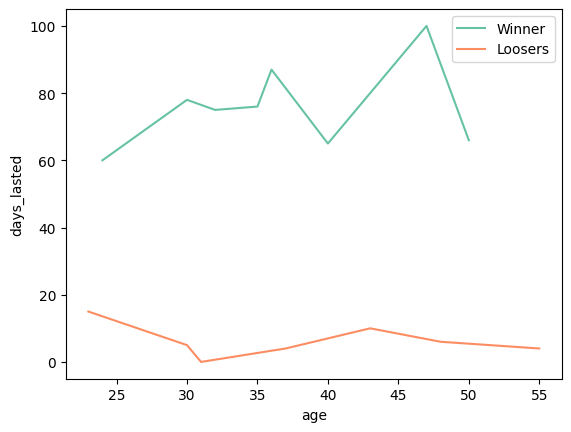

In [ ]:
sns.lineplot(
    data=dfp,
    x='age',
    y='days_lasted',
    palette = 'Set2',
    # legend = True, # Removed as it's not needed with manual patch legend
    hue = 'result',
    errorbar=None
)
plt.legend(['Winner','Loosers'])

In [ ]:
dfw[['season','gender','age','profession','medically_evacuated','country','reason_category','location','days_lasted']]

,season,gender,age,profession,medically_evacuated,country,reason_category,location,days_lasted
0,1,Male,40,Corrections Officer,False,United States,None,Quatsino,56
10,2,Male,50,Writer and Former Missionary,False,United States,None,Quatsino,66
28,3,Male,36,Boat builder,False,United States,None,Patagonia,87
37,4,Male,35,Freelance Writer,False,Canada,None,Quatsino,75
43,4,Male,32,Adventure Videographer,False,Canada,None,Quatsino,75
53,5,Male,24,Wilderness Skills Instructor,False,United States,None,Selenge Province,60
57,6,Male,35,Construction,False,United States,None,Great Slave Lake,77
72,7,Male,47,Hunting Guide,False,United States,None,Great Slave Lake,100
75,8,Male,40,Professional Bowyer & Hunter,False,United States,None,Chilko Lake,74
89,9,Male,30,Outdoor Professional,False,Canada,None,Nunatsiavut,78


#### **Clear distinction based on days lasted**

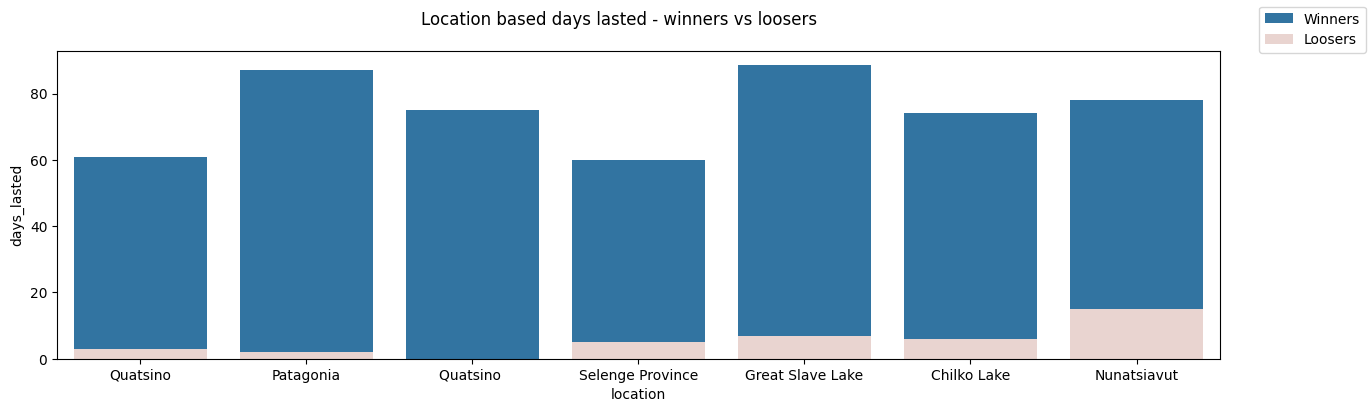

In [ ]:

fig, ax1 = plt.subplots(figsize=(15, 4))
plt.suptitle('Location based days lasted - winners vs loosers')
sns.barplot(data = dfw, x = 'location', y = 'days_lasted',hue = 'result', errorbar = None, ax = ax1, legend = False)

sns.barplot(data = dfl, x = 'location', y = 'days_lasted',hue = 'result', errorbar = None, ax = ax1, legend = False)

fig.legend(['Winners','Loosers'])




**Inference**

- My assumption that both winners and loosers will find a location difficult to survive in is **FALSE**

- Winners found it difficult to survive in Selenge Province in Canada and Quatsino in Canada, as they survived only 60 days. Great Slave Lake was comparitevely the easiest, as they lasted longer.

- Loosers found it difficult to survive in Patagonia in South America. Nunatsiavut in Canada was comparitevely easier for loosers.

- There are two Quatsino as 4 seasons hosted its show in Quatsino. S4 had no loosers therefore the second Quatsino does'nt have any pink color in it.

- A middle ground of difficulty for both winners and loosers would be Quatsino, but more analysis needs to be done about which Quatsino season it was, what factor changed, what characteristics of contestants affected this failure to stay longer in both winners and loosers

#### **Summary - on what basis can we make distinction**

All these EDA provides us with the following information. Lets see the distinction between the categories provided:


| Category   | Winner (Result == 1) | Looser  (Result == 10) |  Distinction (Yes/No) |   |
|---------------------|-------------------------------------------------------------------------------------------------------------|-----------------------------------------------|---|---|
| Country             | There were 10 winners even though there <br>were only 9 seasons because S4 had two winners.<br>Thus 70% US and 30% canadian won | All US<br>No looser for S4                    |  No |   |
| Age Range           | 24-50 <br>Mostly winners in the range 30-35                                                                                  | Range 23-55<br>Mostly 35                      | After 50 no winners. There might be a combination<br> of factors with age can play a role  |   |
| Gender              | Male                                                                                                                            |7/8 Male and 1/8 female                         | No  |   |
| Medically Evacuated | None                                                                                                                            | 2 evacuated one Male (in S6) and one female (S5) | Yes, winners not medically evacuated  |   |
|Locations            | Though most of locations are in Canada S1,S2,S3,S5,S6,S7,S8 US won;<br> where S4,S9 CAD WON                                                                                            | All loosers were from US           | No, As Quastino in S1 and S2 was won by US<br> and S4 were won by Canadian. Also the loosers<br> were from US  |   |
| Days Lasted         | Min 56 max 100 days                                                                                                             | Dont last more than 15 days                   |  Yes Winners last longer |   |
| Profession          |  Both Indoor(writer) and outdoor professionals won<br> however some outdoor professionals who work in tough environments<br> like correction officers and wilderness skills instructors did have the <br>lowest days lasted compared to others like hunting guide and even<br> freelance writers performed better than them                                              |        Both Indoor(writer) and outdoor professionals lost <br> howevers outdoor professionals like wildlife guide <br> lasted longer whereas indoor professional lasted for <br> less period                                       | No not clear  |   |
| Item (gear list)    |   Saw was a distict tool fpr winners                                                                                                              |     Fishing gear was a distinct tool for loosers                                          | No, though there are some common tools,<br> SAW was possesed by all winners but <br> there were 70% loosers using it too   |   |



## Unsupervised ML

#### **Normalization of data**

In [ ]:

d = df[['medically_evacuated','days_lasted','age']]

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_normalized = pd.DataFrame(sc.fit_transform(d), columns=d.columns)

df_normalized

,medically_evacuated,days_lasted,age
0,-0.601929,0.612163,0.234586
1,-0.601929,-1.192834,0.689249
2,-0.601929,-1.373334,0.348252
3,-0.601929,-1.120634,-0.106410
4,-0.601929,-1.265034,-1.584063
...,...,...,...
89,-0.601929,1.406361,-0.902069
90,-0.601929,1.298062,2.166901
91,-0.601929,0.864862,-0.788404
92,1.661325,0.106764,-0.902069


#### **Lets find the best n_clusters**

#### **Heirarichial Clustering**

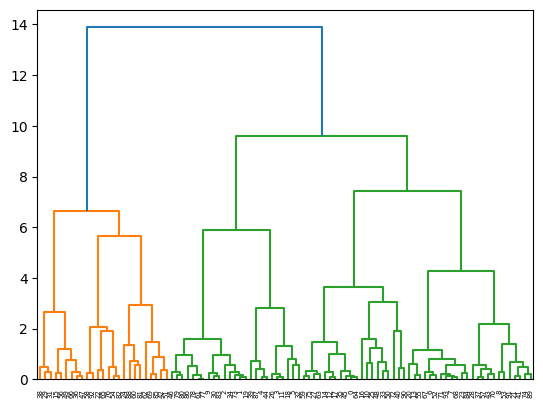

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_samples, silhouette_score


Z = linkage(df_normalized, 'ward') #You may try different methods and distance metrics.

_ = dendrogram(Z,)




In [ ]:
# Source - https://stackoverflow.com/a/20627316
# Posted by Garrett, modified by community. See post 'Timeline' for change history
# Retrieved 2026-02-08, License - CC BY-SA 4.0
pd.options.mode.chained_assignment = None  # default='warn'
lists_w = []
for i in range(2,10):
    n_clusters = i
    df_normalized['cluster_label'] = fcluster(Z, n_clusters, criterion='maxclust').astype(str)
    score = silhouette_score(df_normalized, df_normalized['cluster_label'])
    lists_w.append([i,score])

pd.DataFrame(lists_w, columns = ['n_cluster','silhouette_score'])


,n_cluster,silhouette_score
0,2,0.434892
1,3,0.410171
2,4,0.451547
3,5,0.464426
4,6,0.502302
5,7,0.532655
6,8,0.555862
7,9,0.578106


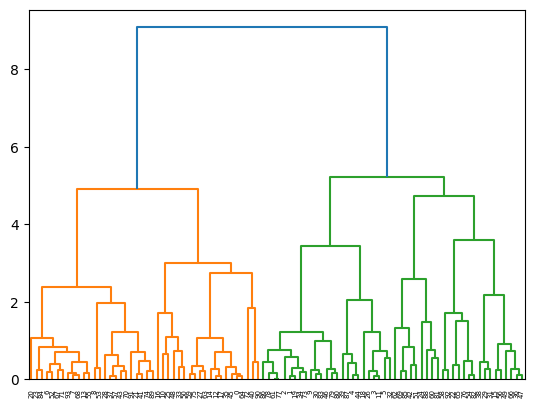

In [ ]:
S = linkage(df_normalized, 'complete') #You may try different methods and distance metrics.

_ = dendrogram(S,)



In [ ]:


lists = []
for i in range(2,10):
    n_clusters = i
    df_normalized['cluster_label'] = fcluster(Z, n_clusters, criterion='maxclust').astype(str)
    score = silhouette_score(df_normalized, df_normalized['cluster_label'])
    lists.append([i,score])

pd.DataFrame(lists, columns = ['n_cluster','silhouette_score'])

,n_cluster,silhouette_score
0,2,0.434892
1,3,0.410171
2,4,0.451547
3,5,0.464426
4,6,0.502302
5,7,0.532655
6,8,0.555862
7,9,0.578106


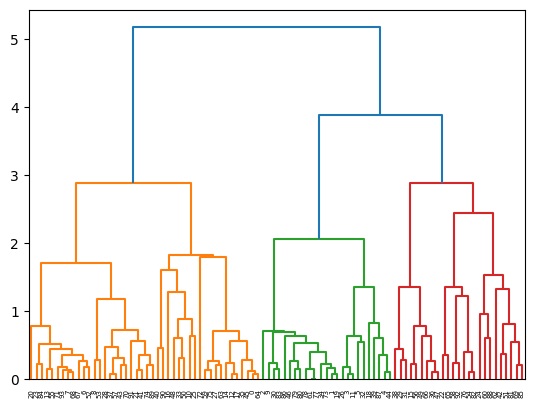

In [ ]:
G = linkage(df_normalized, 'average') #You may try different methods and distance metrics.

_ = dendrogram(G,)


In [ ]:
lists_si = []
for i in range(2,8):
    n_clusters = i
    df_normalized['cluster_label'] = fcluster(Z, n_clusters, criterion='maxclust').astype(str)
    score = silhouette_score(df_normalized, df_normalized['cluster_label'])
    lists_si.append([i,score])

pd.DataFrame(lists, columns = ['n_cluster','silhouette_score'])

,n_cluster,silhouette_score
0,2,0.434892
1,3,0.410171
2,4,0.451547
3,5,0.464426
4,6,0.502302
5,7,0.532655
6,8,0.555862
7,9,0.578106


**Observation**
With all 3 linkage techniques the silhouete score is similar. We can choose based on the dendogram- I found the ward tenchnique better.
Lets choose linkage technique as **'Ward'**
For the number of cluster, there is a still a bit confusion between 6,7,8,9 clusters.

## Lets check using KMeans

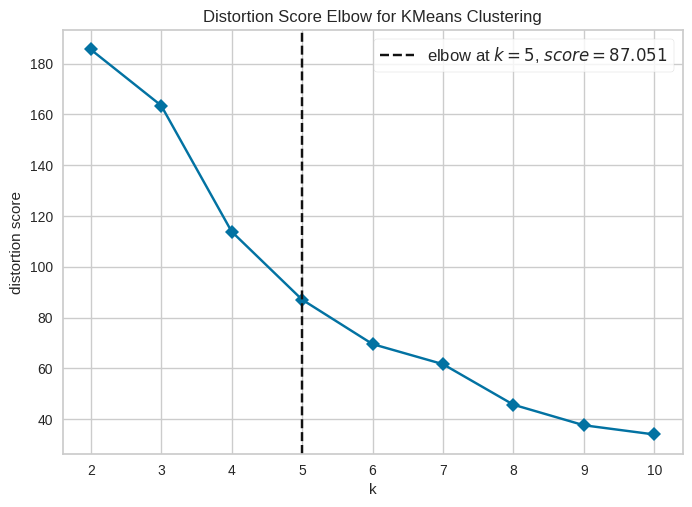

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(KMeans(6,random_state=42), k=(2,11), metric="distortion", timings=False)

visualizer.fit(df_normalized[['days_lasted','medically_evacuated','age']])
visualizer.show()


**Observation** In this case 6,7,8 looks like the elbow, 8 has a higher silhouete score of 0.55 compared to 6 and 7. The distortion score of 8 is the lowest. Howvers, its a larger number of clusters which does'nt quite help the directors pin points the cast easily. We can either take 6 or 7. Lets take 6 in this case as the silhouette score is 0.502 and it looks more like an elbow. A cluster of 6 is more managable is terms of casting survivalist than 8.

In [41]:
kmeans_result = KMeans(n_clusters = 6).fit(df_normalized[['age', 'days_lasted','medically_evacuated']])  #, init = [[2, 1 ],[0, 0]] ,init='random'

kmeans_result.cluster_centers_

df_normalized['cluster_labels'] = kmeans_result.labels_



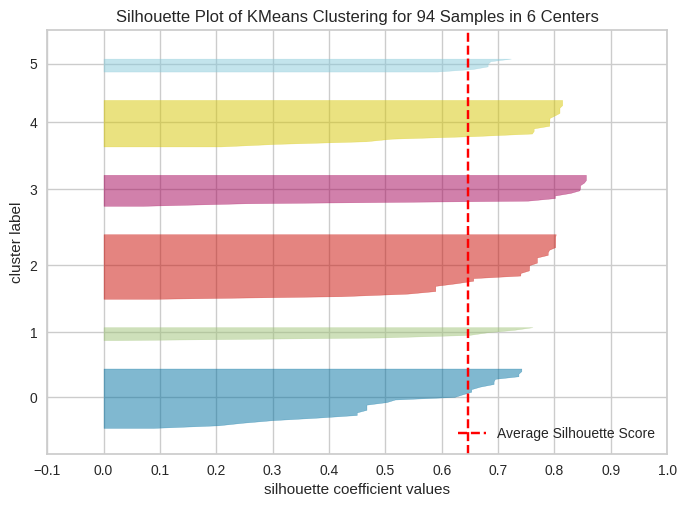

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 94 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [42]:

from yellowbrick.cluster import SilhouetteVisualizer

kmeans_model = KMeans(6, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick', timings=False)

visualizer.fit(df_normalized[['days_lasted','medically_evacuated']])        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**Inference**
- The average score is 0.6, its know that a silhouette score above 0.5 is considered good.
- As 0.6 is closer to 1 we can say that, it is well seperated clusters
- There are 6 clusters based on three features. This can be due to the variability of a combination of features. As there might be other features that together impact the datapoint to be in the cluster.
- I had also tried with 8 clusters as it had a higher silhouette score based on hierarchical clustering though it gave better results, I think there might be other features that need to be taken together as they might impact the datapoint  in a combinatorial way.
- I also tried removing one of the features namely `age` and the whole clustering becomes into 2 distinct clusters that are winner and losers, but this should not be the case a show must include all kinds of participants in order to create hype and engagement with viewers.


In [ ]:
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')
import plotly.express as px
n_cluster = 6
df_normalized['cluster_label'] = fcluster(Z, n_cluster, criterion='maxclust').astype(str)

fig = px.scatter_3d(df_normalized, x='age', y='days_lasted', z='medically_evacuated',color='cluster_label')
fig.show()

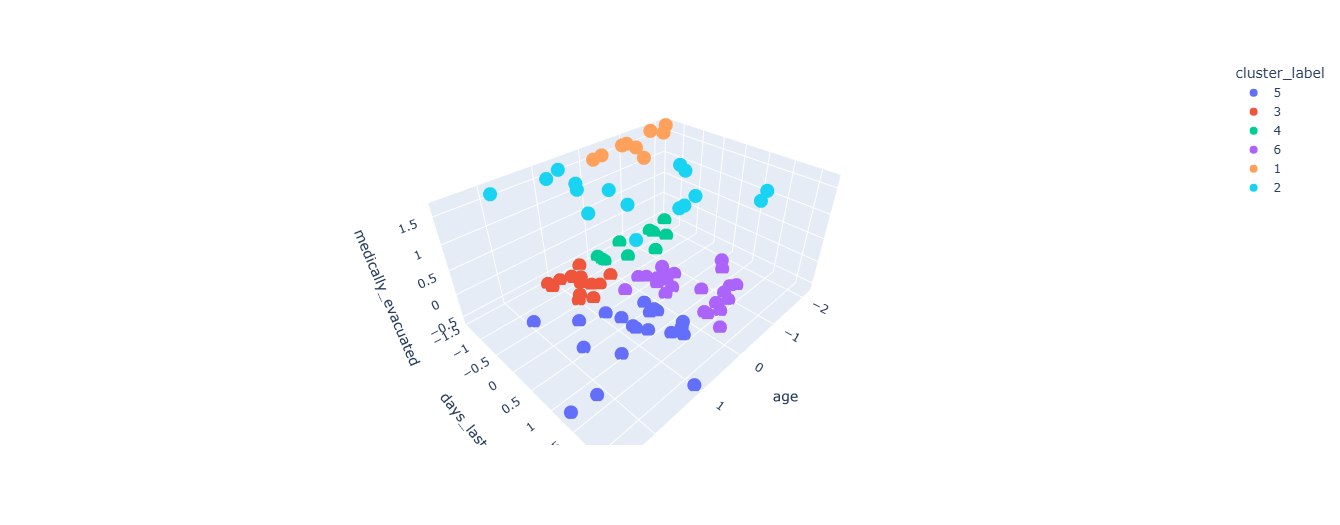

##**Insights**

- Stakeholders can now use these 6 clusters to find participants who will comprise of winners, loosers and others in between

- Casting directors need to cast people who have no medical history, or have stronger immunity to harsh climates

- Though age cannot be used on its own, we saw that males after 50 dont win. So casting directors depending can select those candidates before the age of 50. Somewhere around 30-40. These age range can be further broken down and analysed based on other combinatorial features.

###**Reference**

1. [Python Graph Gallery](https://python-graph-gallery.com/treemap/)
2. [stat.cmu](https://www.stat.cmu.edu/capstoneresearch/fall2023/315files_f23/team10.html)
3. [stackoverflow.com](https://stackoverflow.com/questions)
4. [wiki](https://en.wikipedia.org/wiki/)
5. [Professor Elahmod](https://github.com/elhamod/BA820/)
6. [scikit](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)
7. [Medium study](https://gursev-pirge.medium.com/a-comparative-study-of-various-clustering-algorithms-c356fc427a40)
8. [Medium Linkage](https://medium.com/@iqra.bismi/different-linkage-methods-used-in-hierarchical-clustering-627bde3787e8)
9. [Geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/ml-types-of-linkages-in-clustering/)
10. [Plotly scatter 3D](https://plotly.com/python/3d-scatter-plots/)
11. [Pandas melt youtube](https://www.youtube.com/watch?v=ezf2Slns0Bo)
12. [Github solutions](https://github.com/BayraktarLab/cell2location/issues/322)
13. [Dropping Nans pandas](https://sparkbyexamples.com/pandas/pandas-drop-rows-with-nan-values-in-dataframe/)
14. [Dendograms](https://codesignal.com/learn/courses/hierarchical-clustering-deep-dive/lessons/understanding-dendrograms-with-python-in-hierarchical-clustering)
15. [Distance Clustering](https://www.data-mania.com/blog/customer-profiling-and-segmentation-in-python/)

####**Generative AI Disclosure**

ChatGPT was not used for this Phase M2. I relied on google search and on professors github files.



####**Next steps:**


1. Find further similarity between professions - as all professions look different in name but can be categorized or can be similar to some outdoor professions like wildlife jobs

2. Find out out whether viewers like when participants are tapping out - if there are more viewers people would want to see what led to such tapping out. If not they are only concerned about winners and the casting directors can use the winners clusters in the next seasons.

3. Find alternative for medically_evacuated column, currently has binary values which was then normalized for clustering.